In [2]:
import numpy as np

gt = np.load('../runs/kol/20/gtNpy.npy')
pred = np.load('../runs/kol/20/predNpy.npy')




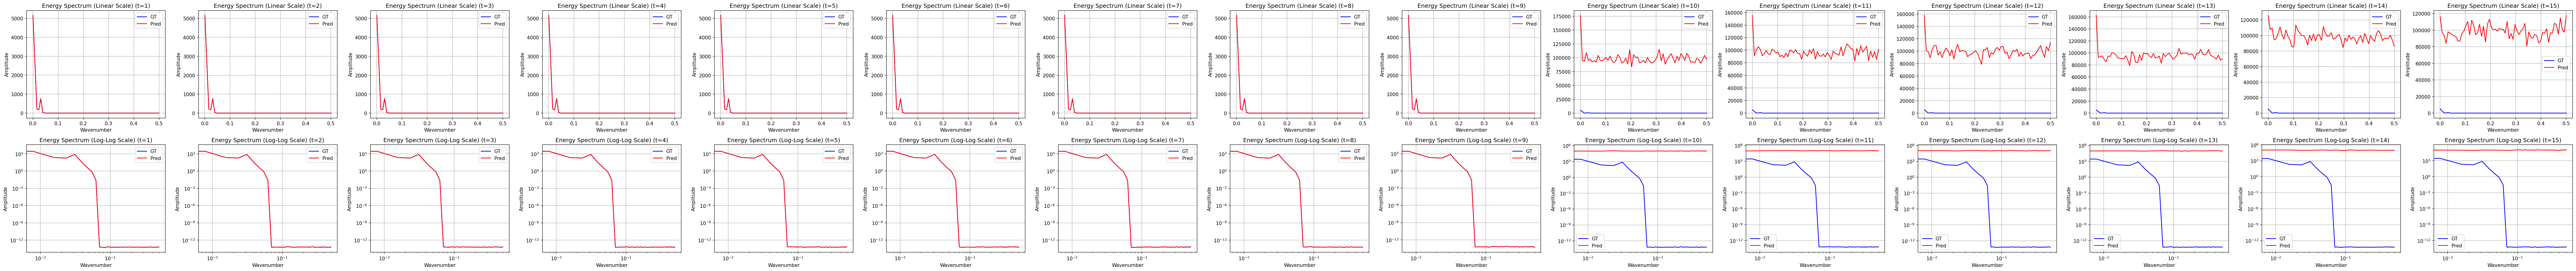

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Assuming gt and pred are numpy arrays of shape [1, 1, T, 1, H, W]
# Extract the relevant dimensions (T, H, W)
T = gt.shape[2]
H, W = gt.shape[4], gt.shape[5]

fig, axs = plt.subplots(nrows=2, ncols=T, figsize=(T * 5, 2 * 4), dpi=150, squeeze=False)

# Loop through each timestamp to calculate and plot the combined energy spectrum
for t in range(T):
    # Extract gt and pred arrays at timestamp t
    gt_t = gt[0, 0, t, 0, :, :]
    pred_t = pred[0, 0, t, 0, :, :]
    
    # Round up the size along each axis to an even number
    n_H = int(math.ceil(H / 2.) * 2)
    n_W = int(math.ceil(W / 2.) * 2)
    
    # Compute the 2D Fourier transform for gt and pred using rfft along both axes
    fft_gt_x = np.fft.rfft(gt_t, n=n_W, axis=1)
    fft_gt_y = np.fft.rfft(gt_t, n=n_H, axis=0)

    fft_pred_x = np.fft.rfft(pred_t, n=n_W, axis=1)
    fft_pred_y = np.fft.rfft(pred_t, n=n_H, axis=0)
    
    # Compute power spectrum (multiply by complex conjugate)
    energy_gt_x = fft_gt_x.real ** 2 + fft_gt_x.imag ** 2
    energy_gt_y = fft_gt_y.real ** 2 + fft_gt_y.imag ** 2

    energy_pred_x = fft_pred_x.real ** 2 + fft_pred_x.imag ** 2
    energy_pred_y = fft_pred_y.real ** 2 + fft_pred_y.imag ** 2

    # Average over appropriate axes
    energy_gt_x = energy_gt_x.sum(axis=0) / fft_gt_x.shape[0]
    energy_gt_y = energy_gt_y.sum(axis=1) / fft_gt_y.shape[1]

    energy_pred_x = energy_pred_x.sum(axis=0) / fft_pred_x.shape[0]
    energy_pred_y = energy_pred_y.sum(axis=1) / fft_pred_y.shape[1]

    # Combine energies for a single spectrum
    energy_gt = 0.5 * (energy_gt_x + energy_gt_y)
    energy_pred = 0.5 * (energy_pred_x + energy_pred_y)

    # Generate wavenumber axis (only for positive frequencies)
    wavenumber_x = np.fft.rfftfreq(n_W)
    wavenumber_y = np.fft.rfftfreq(n_H)

    # Since energy_gt and energy_pred are averaged over x and y axes, 
    # we use the wavenumber from one of the axes (they represent equivalent ranges)
    wavenumber = wavenumber_x  # or wavenumber_y, since the final energy spectrum is averaged

    # Sort wavenumber and energy values in descending order
    sorted_indices = np.argsort(wavenumber)[::-1]
    wavenumber_sorted = wavenumber[sorted_indices]
    energy_gt_sorted = energy_gt[sorted_indices]
    energy_pred_sorted = energy_pred[sorted_indices]

    # Plotting the combined energy spectrum for gt and pred (linear scale)
    axs[0, t].plot(wavenumber_sorted, energy_gt_sorted, label='GT', color='blue')
    axs[0, t].plot(wavenumber_sorted, energy_pred_sorted, label='Pred', color='red')
    axs[0, t].set_title(f"Energy Spectrum (Linear Scale) (t={t+1})")
    axs[0, t].set_xlabel('Wavenumber')
    axs[0, t].set_ylabel('Amplitude')
    axs[0, t].grid(True)
    axs[0, t].legend()

    # Plotting the combined energy spectrum for gt and pred (log-log scale)
    axs[1, t].plot(wavenumber_sorted, energy_gt_sorted, label='GT', color='blue')
    axs[1, t].plot(wavenumber_sorted, energy_pred_sorted, label='Pred', color='red')
    axs[1, t].set_xscale('log')
    axs[1, t].set_yscale('log')
    axs[1, t].set_title(f"Energy Spectrum (Log-Log Scale) (t={t+1})")
    axs[1, t].set_xlabel('Wavenumber')
    axs[1, t].set_ylabel('Amplitude')
    axs[1, t].grid(True)
    axs[1, t].legend()

# Adjust layout for better viewing
plt.tight_layout()
plt.show()



## Claude

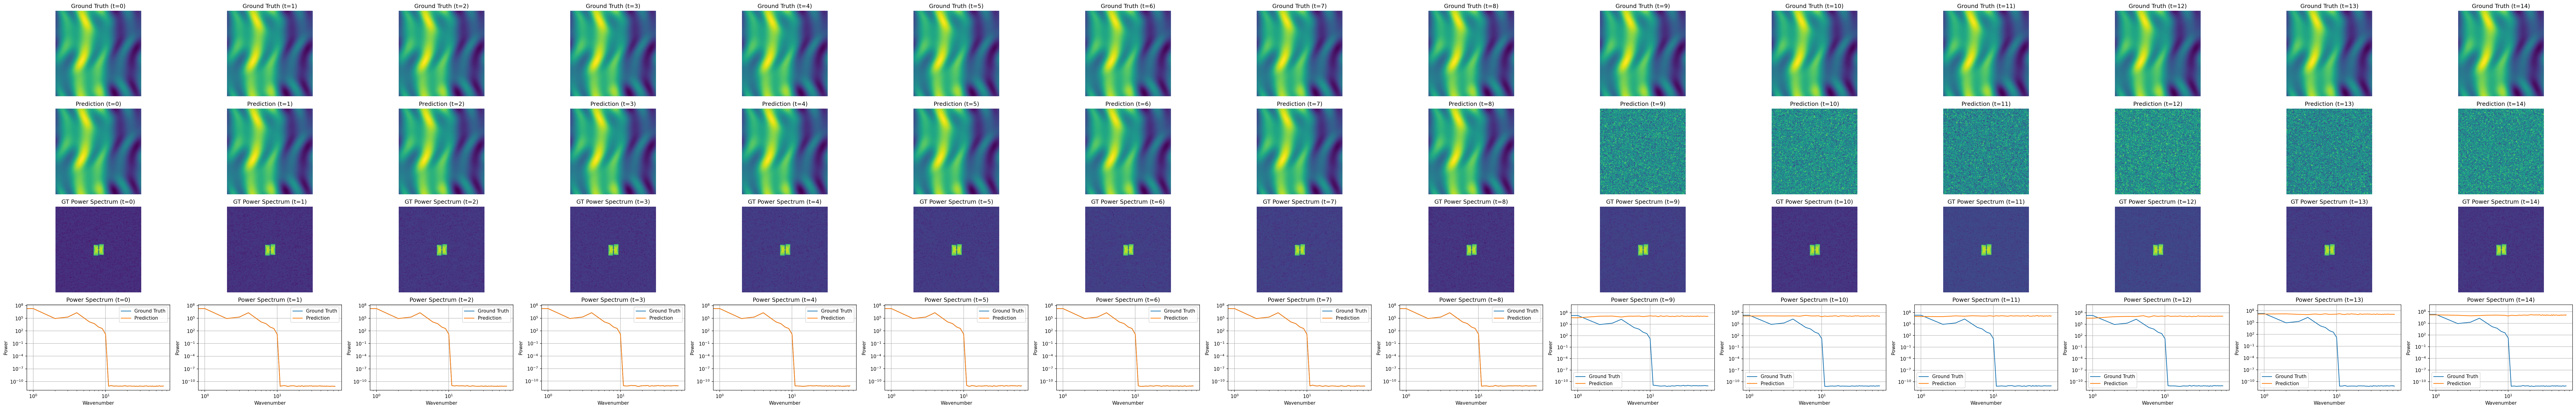

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def compute_2d_power_spectrum(signal):
    # Compute the 2D Fourier Transform
    f_transform = np.fft.fft2(signal)
    
    # Shift the zero frequency component to the center
    f_transform_shifted = np.fft.fftshift(f_transform)
    
    # Compute the power spectrum
    power_spectrum = np.abs(f_transform_shifted)**2
    
    return power_spectrum

def radial_profile(data, center):
    y, x = np.indices(data.shape)
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(int)
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile

def plot_power_spectrum_comparison(gt, pred):
    # Assuming gt and pred are numpy arrays of shape [1, 1, T, 1, H, W]
    # Extract the relevant dimensions (T, H, W)
    T = gt.shape[2]
    H, W = gt.shape[4], gt.shape[5]

    fig, axs = plt.subplots(nrows=4, ncols=T, figsize=(T * 5, 4 * 3), dpi=150, squeeze=False)

    # Loop through each timestamp to calculate and plot the combined energy spectrum
    for t in range(T):
        # Extract gt and pred arrays at timestamp t
        gt_t = gt[0, 0, t, 0, :, :]
        pred_t = pred[0, 0, t, 0, :, :]

        # Compute power spectra
        ps_gt = compute_2d_power_spectrum(gt_t)
        ps_pred = compute_2d_power_spectrum(pred_t)

        # Compute radial profiles
        center = (H // 2, W // 2)
        rp_gt = radial_profile(ps_gt, center)
        rp_pred = radial_profile(ps_pred, center)

        # Compute wavenumbers
        k = np.fft.fftfreq(H, d=1/H)[:H//2]

        # Plot original signals
        axs[0, t].imshow(gt_t, cmap='viridis')
        axs[0, t].set_title(f'Ground Truth (t={t})')
        axs[0, t].axis('off')

        axs[1, t].imshow(pred_t, cmap='viridis')
        axs[1, t].set_title(f'Prediction (t={t})')
        axs[1, t].axis('off')

        # Plot power spectra
        axs[2, t].imshow(np.log10(ps_gt), cmap='viridis')
        axs[2, t].set_title(f'GT Power Spectrum (t={t})')
        axs[2, t].axis('off')

        axs[3, t].loglog(k, rp_gt[:H//2], label='Ground Truth')
        axs[3, t].loglog(k, rp_pred[:H//2], label='Prediction')
        axs[3, t].set_xlabel('Wavenumber')
        axs[3, t].set_ylabel('Power')
        axs[3, t].set_title(f'Power Spectrum (t={t})')
        axs[3, t].legend()
        axs[3, t].grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have gt and pred arrays of shape [1, 1, T, 1, H, W]
# gt = ...
# pred = ...
plot_power_spectrum_comparison(gt, pred)



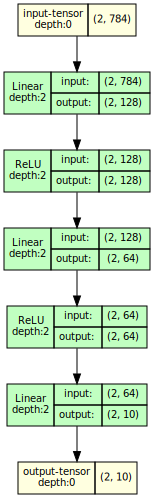

In [5]:
from torchview import draw_graph
import torch

import torch
import torch.nn as nn

# Define the MLP class
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(SimpleMLP, self).__init__()
        layers = []
        in_dim = input_size
        # Add hidden layers
        for h_dim in hidden_sizes:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.ReLU())
            in_dim = h_dim
        # Add output layer
        layers.append(nn.Linear(in_dim, output_size))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Instantiate the MLP
input_size = 784            # Example input size (e.g., 28x28 images flattened)
hidden_sizes = [128, 64]    # Hidden layers with 128 and 64 neurons
output_size = 10            # Example output size (e.g., 10 classes for classification)

mlp = SimpleMLP(input_size, hidden_sizes, output_size)


batch_size = 2
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(mlp, input_size=(batch_size, 784), device='cpu')
model_graph.visual_graph